# Exploratory data analysis on the Reuters 21578 dataset


 Reuters-21578 dataset is a collection of documents with news articles. The dataset is used as a benchmark in multiple articles and academic courses that discuss natural language processing
 
 ### 1. Reading the data
 
 The source consists of 22 files in SGML format. The following code uses BeatifulSoup to extract all the tag information into a pandas dataframe

In [10]:
import os
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.corpus import words
#from wordcloud import WordCloud
from nltk import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings("ignore")


param_location = '../data/reuters_21578/'


def read_reuters_sgm2(location = param_location, size = 0):
    '''Read SGM files containing Reuters annotated article fomat
    Return a list corresponding to the parsed articles 
    
    Use size to limit the number of files read, for faster testing
    '''
    res_list = []
    file_list = [e for e in os.listdir(location) if e.endswith(".sgm")]    
    #Limit for faster testing purposes 
    if size:
        file_list = file_list[:size]
    for file in tqdm(file_list):
        filename = os.path.join(location, file)
        #print(filename)
        f = open(filename, 'r', encoding='utf-8', errors='ignore')
        dataFile = f.read()
        soup = BeautifulSoup(dataFile, 'html.parser')
        for item in soup.findAll('reuters'): 
            res = {}
            #Title, PLACES, people, orgs, EXCHANGES, COMPANIES, AUTHOR
            for feature in ['places', 'people', 'orgs', 'exchanges', 'companies', 'author','body','title','topics']:
                res[feature] = item.find(feature)
            res['lewissplit'] = item['lewissplit']
            res_list.append(res)
        #break
    return res_list

def read_d_list(item):
    '''Find all the <d> tags in the item
    '''
    try:
        return [e.text for e in item.findAll('d')]
    except:
        return []

def extract_author(v):
    try:
        v = v.lower()
        #Extract the Author Name using regex
        #res = re.match(r'\s*by\s+(.+?),\s+reuters', v)        
        res = re.match(r'\s*by\s+([^,]+),?.*', v)        
        if res:
            #print(res.group(1))
            return res.group(1)
        else:
            return v
    except:
        return ''

In [11]:
# Parse the input data and display the statistics
res_list = read_reuters_sgm2()
reuters_df = pd.DataFrame(res_list)
print(f'Number of articles: {reuters_df.shape[0]}')
print('NA counts across the features extracted:')
print(reuters_df.isna().sum())


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:24<00:00,  1.12s/it]

Number of articles: 21578
NA counts across the features extracted:
places            0
people            0
orgs              0
exchanges         0
companies         0
author        20703
body           2535
title           737
topics            0
lewissplit        0
dtype: int64


### 2. Preprocessing and analysis

Multiple features need to be clean-up to improve the quality of the information contained within

1. Multiple features contain tagged lists that needs to be extracted 
2. The author contains mixed casing, spacing and annotations. Processed and brought to standard formating 

In [12]:
print('Inconsistent formating for the author values:')
print(reuters_df.author.value_counts())


Inconsistent formating for the author values:
[    By Chaitanya Kalbag, Reuters]    23
[    By Rich Miller, Reuters]         22
[    By Peter Torday, Reuters]        17
[    By Patti Domm, Reuters]          15
[    By Cal Mankowski, Reuters]       14
                                      ..
[    By MAAMOUN YOUSSEF, Reuters]      1
[    By Peter Elsworth]                1
[    By Myra MacDonald, Reuters]       1
[    By Keith Leighty]                 1
[    By Rie Sagawa]                    1
Name: author, Length: 351, dtype: int64


In [13]:
# Handle text conversion:
def get_text(v):
    try:
        return v.text
    except AttributeError:
        # v is null
        return ''
    
#These tags contain only one element:
for col in ['body','title','author']:    
    reuters_df[col]=reuters_df[col].apply(get_text)
#These tags contain a posible list:
for col in ['topics', 'places','people','orgs','exchanges','companies']:
    reuters_df[col] = reuters_df[col].apply(read_d_list)


[Text(0, 0, '352'), Text(0, 0, '243')]

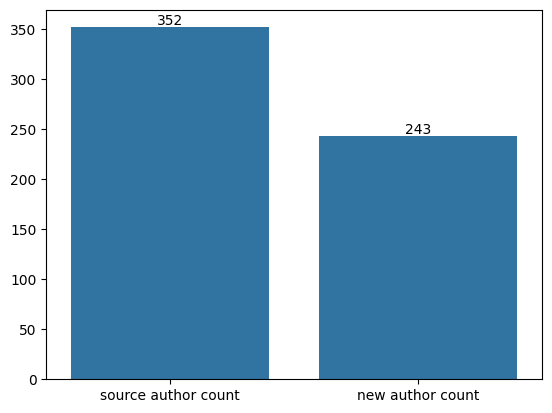

In [14]:
# DISPLAY - author name is a mixure of uppercase and normal typing => can be improved by extracting the name in a standard format 
src_author_count = reuters_df.author.nunique()
reuters_df.author = reuters_df.author.apply(extract_author)
new_author_count = reuters_df.author.nunique()

ax = sns.barplot( x = ['source author count', 'new author count'], y = [src_author_count, new_author_count])
ax.bar_label(ax.containers[0])


3.  A large number of articles do not have any topics associated with them. Depending on the data qualitiy, it can be possible to use these articles as negative example indicating that a topic cannot be applied.

However, as the `README.txt` file mentions, the labeling of this dataset is inconsistent and the most straighforward approach is to simply discard the articles without labeled topics.

4. There are articles with multiple topics and by exploding the topics list we can generate additional datapoints. This helps especially with the minority topics as most classification belong to just a few topic classes

**Caviat**: this assumes that article with multiple topics such as `[silver, copper]` or `[coffee, tea, rubber]` belong in equal measure to each of the topics. It also gives additional weight to such articles

Percentage of article with topics: 52.7%
Datasize increase by allowing multiple topics: 125.8%


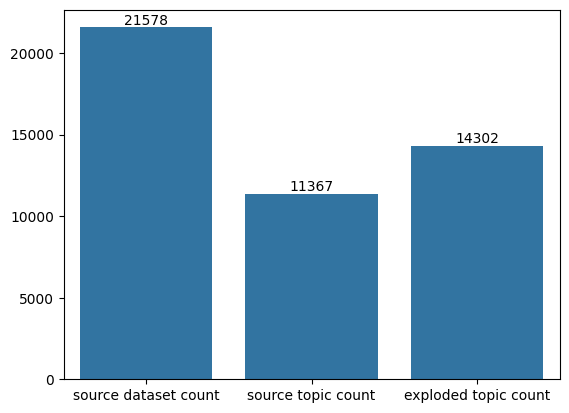

In [15]:
src_dataset_count = reuters_df.shape[0]
src_topic_count = reuters_df.topics.apply(lambda v: len(v)>0).sum()
reuters_df = reuters_df.explode('topics')
# Dropna articles with mising topics
reuters_df.dropna(subset = ['topics'], inplace = True)
new_topic_count = reuters_df.shape[0]
 
ax = sns.barplot( x = ['source dataset count', 'source topic count', 'exploded topic count'], 
                 y = [src_dataset_count, src_topic_count, new_topic_count])
ax.bar_label(ax.containers[0])
print(f'Percentage of article with topics: {src_topic_count/src_dataset_count:.1%}')
print(f'Datasize increase by allowing multiple topics: {new_topic_count/src_topic_count:.1%}')


5.  Perform standard NLP data preprocessing:
- lower case, filter to letter set, remove tags and other punctuation elements
- remove stopwords
- lemmatize
Each operation reduces the number of distinct words in the articles as non-significant elements or words variations are eliminated

Decrease of distinct word count in articles


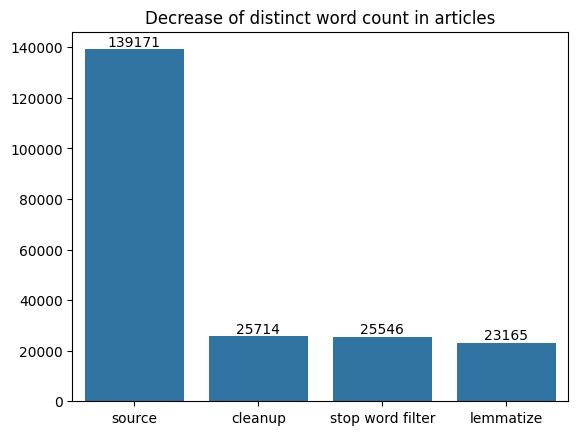

In [17]:
#reuters_df.to_csv('reuters_processed.csv', index = False)

# Concat lists into space separated strings
for col in ['places','people','orgs','exchanges','companies']:
    reuters_df[col + '_str'] = reuters_df[col].apply(lambda e: ' '.join(e))
# Change the column names:
reuters_df.rename(columns = {'body':'articles', 'topics':'topic'}, inplace = True)    

#count the number of distinct words after each step
def count_distinct_word(reuters_df, col):
    return len(set(' '.join(reuters_df[col]).split(' ')))

source_distinct_word_cnt = count_distinct_word(reuters_df, "articles")
#print(source_distinct_word_cnt)


def clean_articles(row):
    ''' String cleanup: remove url link and tags.
    Remove special characters and numbers 
    Lower text case
    '''
    # remove url links
    row = re.sub("http\s+", '', row)
    # remove html tags
    row = re.sub("<[^<]+?>", '', row)
    # remove special characters, numbers and punctuations
    row = re.sub("[^A-za-z+ ]", ' ', row)
    # lower the text
    row = row.lower()
    return row

reuters_df["articles_cln"]=reuters_df["articles"].apply(clean_articles)
#print(f'Distinct word count in sources articles: {count_distinct_word(reuters_df, "articles")}')
cleanup_distinct_word_cnt = count_distinct_word(reuters_df, "articles_cln")
#print(cleanup_distinct_word_cnt)


def tokenize_remove_stopword(row, min_length = 2, stop_words = []):
    ''' remove stopwords and words that have length less than min_length
    '''
    row = " ".join(word for word in nltk.wordpunct_tokenize(row) if len(word)>= min_length and word not in stop_words)
    return row

min_word_length = 2
stop_words=stopwords.words("English")
reuters_df["articles_cln"]= reuters_df["articles_cln"].apply(lambda x:tokenize_remove_stopword(x, min_word_length, stop_words))
nostops_distinct_word_cnt = count_distinct_word(reuters_df, "articles_cln")
#print(nostops_distinct_word_cnt)


def join_token_lemmatize(s, lemmatizer):
    '''Lemmatize over space joined tokens
    '''
    l = s.split(' ')
    s = ' '.join([lemmatizer.lemmatize(e) for e in l])
    return s

lemmatizer = WordNetLemmatizer()
reuters_df["articles_cln"] = reuters_df["articles_cln"].apply(lambda x: join_token_lemmatize(x, lemmatizer))
lemmat_distinct_word_cnt = count_distinct_word(reuters_df, "articles_cln")
#print(lemmat_distinct_word_cnt)

ax = sns.barplot( 
    x = ['source', 'cleanup', 'stop word filter','lemmatize'], 
    y = [source_distinct_word_cnt, cleanup_distinct_word_cnt, nostops_distinct_word_cnt, lemmat_distinct_word_cnt])
ax.bar_label(ax.containers[0])
ax.set_title('Decrease of distinct word count in articles')
print('Decrease of distinct word count in articles')

## 3. Selecting the topic distribution

The reuters dataset contains 120 topics but most of the are under-represented. Based on the topic distribution analysis we selected the top 9 topics for prediction. All remaining topics are grouped under the `other` topic.


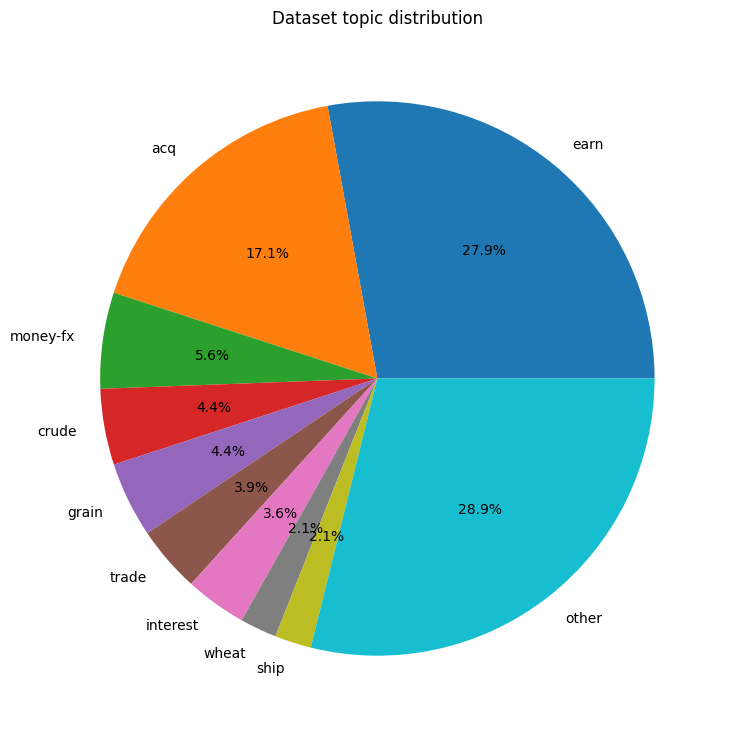

In [29]:
# %% Explore the topic distribution

x = reuters_df.topic.value_counts().to_frame().reset_index()

x = reuters_df.topic.value_counts(normalize = True).to_frame().reset_index()
x.columns = ['label','val']
#Keep the 1st 9 topics to predict
no_topic = 9
x = x[:no_topic]
topic_list = x.label.to_list()
y = pd.DataFrame([{'label':'other', 'val':1 - x.val.sum()}])
x = pd.concat([x, y])
topic_list = topic_list + ['other']

plt.figure(figsize=(9,9)) # Set figure size
plt.pie(x = x.val, labels = x.label, autopct='%.1f%%')
plt.title('Dataset topic distribution')
plt.show()

reuters_df['topic_simple'] = reuters_df.topic.apply(lambda v: v if v in topic_list else 'other')


## 4.  Do a multi-class classification based on Logistic progression

For a simple start use the tf-idf encoding to encode the article data. 

Then do a mult-classification using `LogisticRegression` in `multinomial` mode

In [30]:
#Split the train and test dataframes:
mask_train = reuters_df["lewissplit"]=="TRAIN"
tfidf = TfidfVectorizer(min_df=5)
# Train a Tfidf word vectorizarion on **only the train dataset**
tfidf.fit(reuters_df.loc[mask_train,'articles'].to_list())
# Word vectorisation
x = tfidf.transform(reuters_df["articles"].tolist())
X_train = x[mask_train]
X_test = x[~mask_train]
y_train = reuters_df.loc[mask_train, 'topic_simple']
# multi-lcassification
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X_train, y_train)
pred = model.predict(x) #predict for everything
reuters_df['topic_pred'] = pred
y_test = reuters_df.loc[~mask_train, 'topic_simple']
y_pred = reuters_df.loc[~mask_train, 'topic_pred']

from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay


# get the multi-label confusion matrix
mcm = multilabel_confusion_matrix(y_test, y_pred,
            labels= topic_list)

cm = confusion_matrix(y_test, y_pred,
            labels= topic_list)



Generate the prediction heatmap that shows actual x predicted matrix including all classes

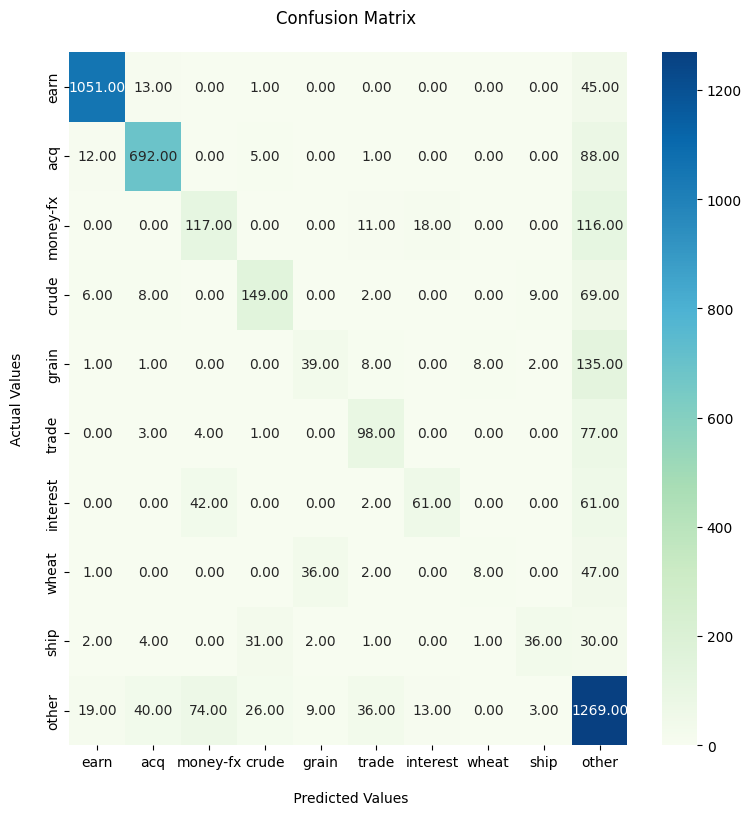

In [32]:
def plot_mcm_heatmap(cm, labels, title = 'Confusion Matrix \n'):
    plt.figure(figsize=(9,9))
    fx=sns.heatmap(cm, annot=True, fmt=".2f",cmap="GnBu")
    fx.set_title(title);
    fx.set_xlabel('\n Predicted Values\n')
    fx.set_ylabel('Actual Values\n');
    fx.xaxis.set_ticklabels(labels)
    fx.yaxis.set_ticklabels(labels)
    plt.show()

def plot_cm_heatmap(cm, title = 'Confusion Matrix \n'):
    plt.figure(figsize=(9,9))
    fx=sns.heatmap(cm, annot=True, fmt=".2f",cmap="GnBu")
    fx.set_title(title);
    fx.set_xlabel('\n Predicted Values\n')
    fx.set_ylabel('Actual Values\n');
    fx.xaxis.set_ticklabels([True, False])
    fx.yaxis.set_ticklabels([True, False])
    plt.show()

def mcm_to_cm(mcm):
    '''
    # Multi-label MCM is [[TN, FP], [FN, TP]] - TN and TP are switched
    # Ordinary confusion matrix is [[TP,FP],[FN,TN]]
    '''
    cm = np.array([[mcm[1,1], mcm[0,1]],[mcm[1,0],mcm[0,0]]])
    return cm

plot_mcm_heatmap(cm, topic_list)




 Show the individual confusion matrix for each class. These are obtained by spliting between `current class / all not current`.
 The values can be used to compute the **micro scores** for each class separately

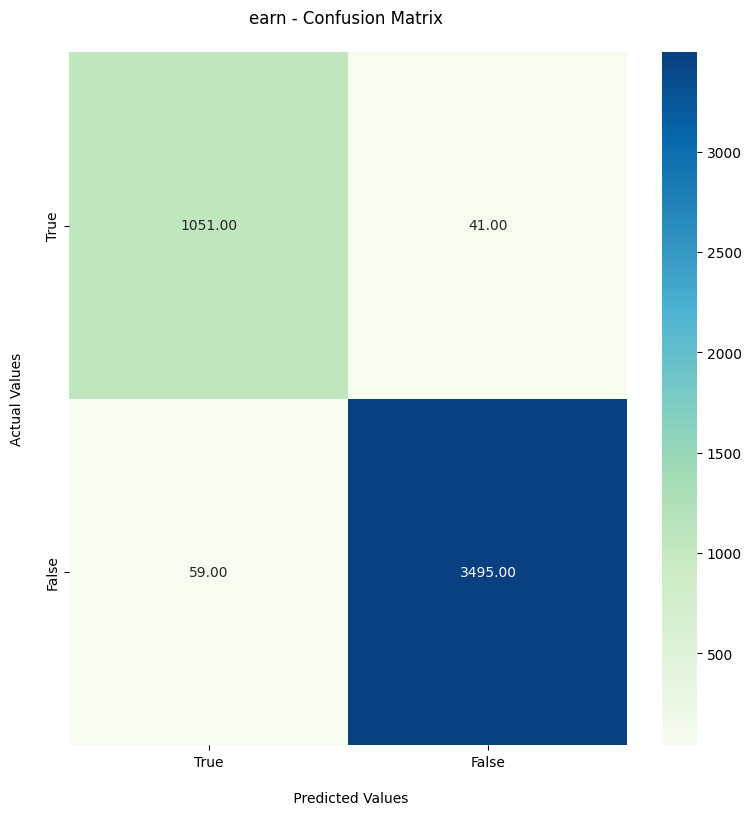

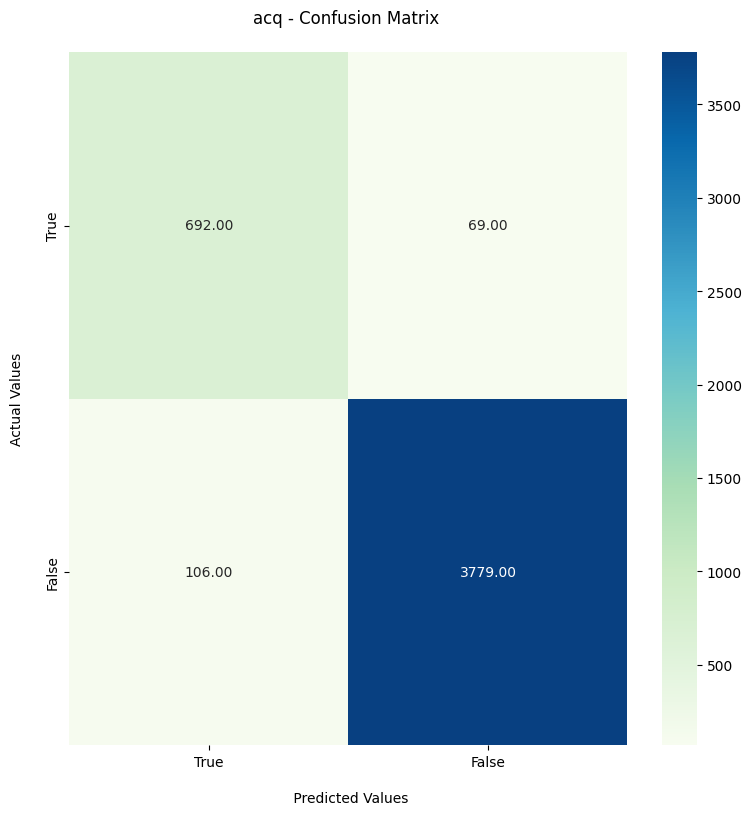

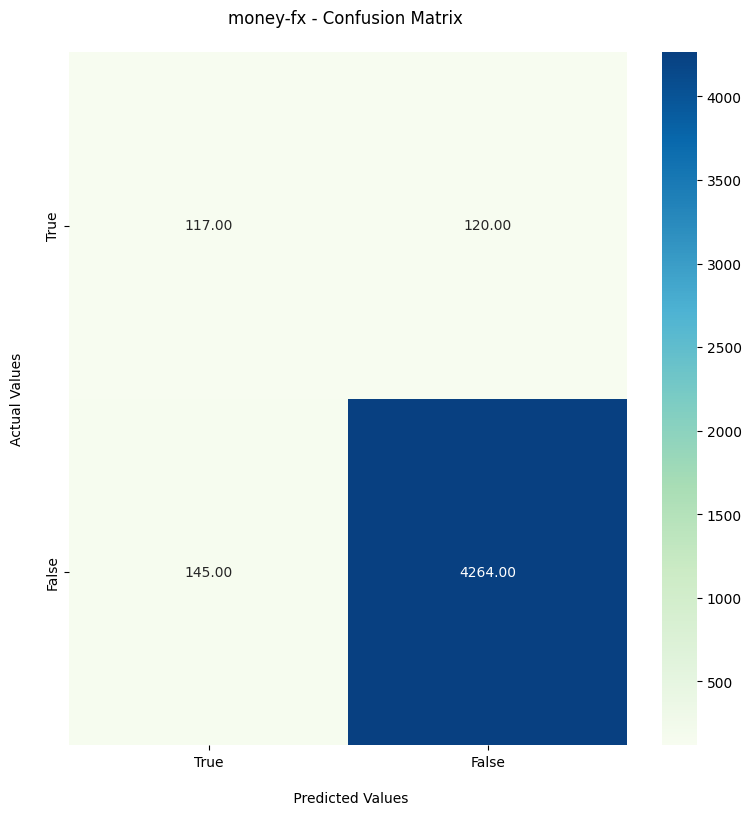

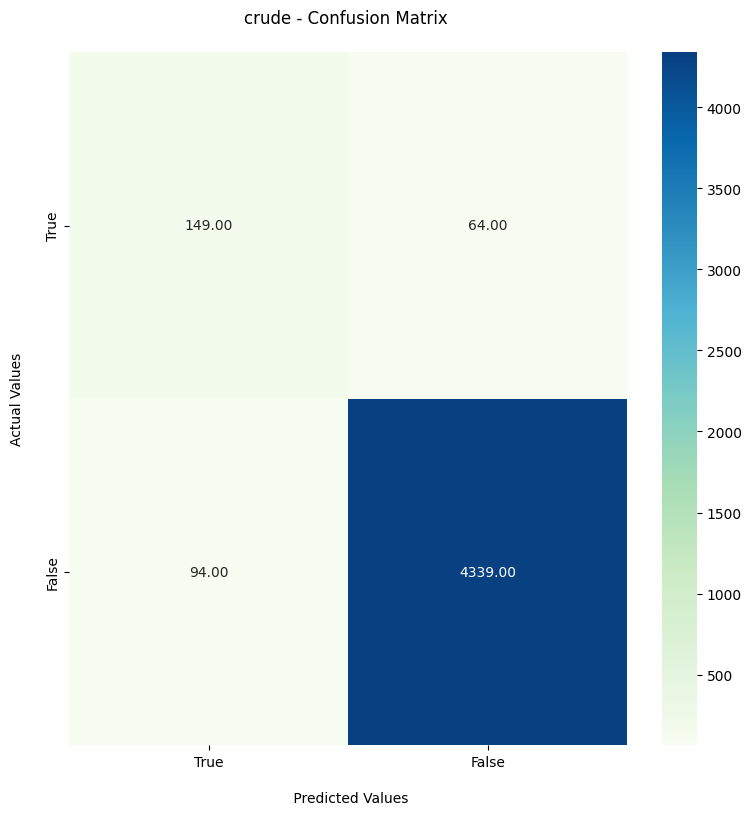

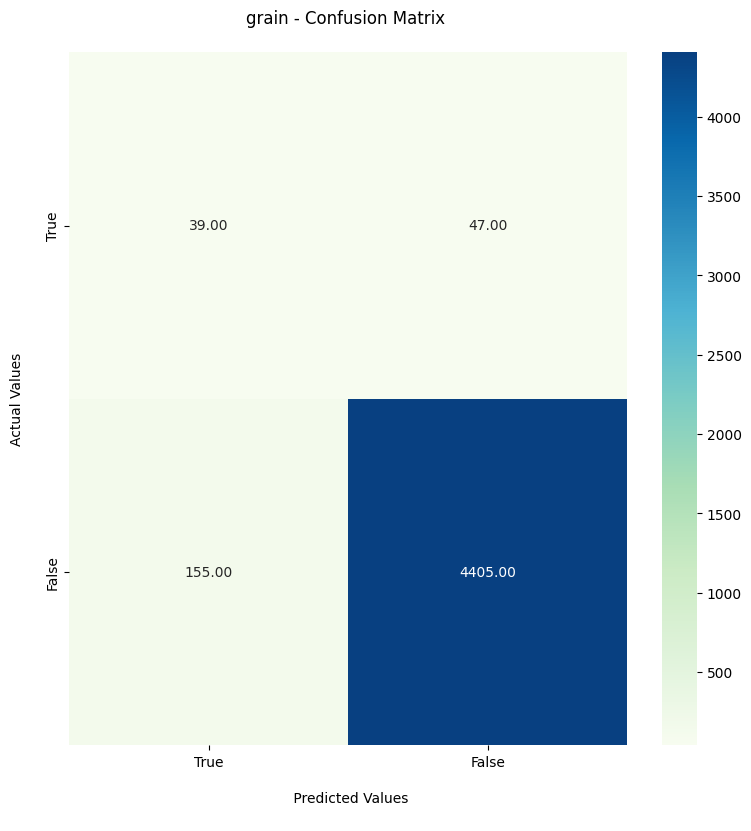

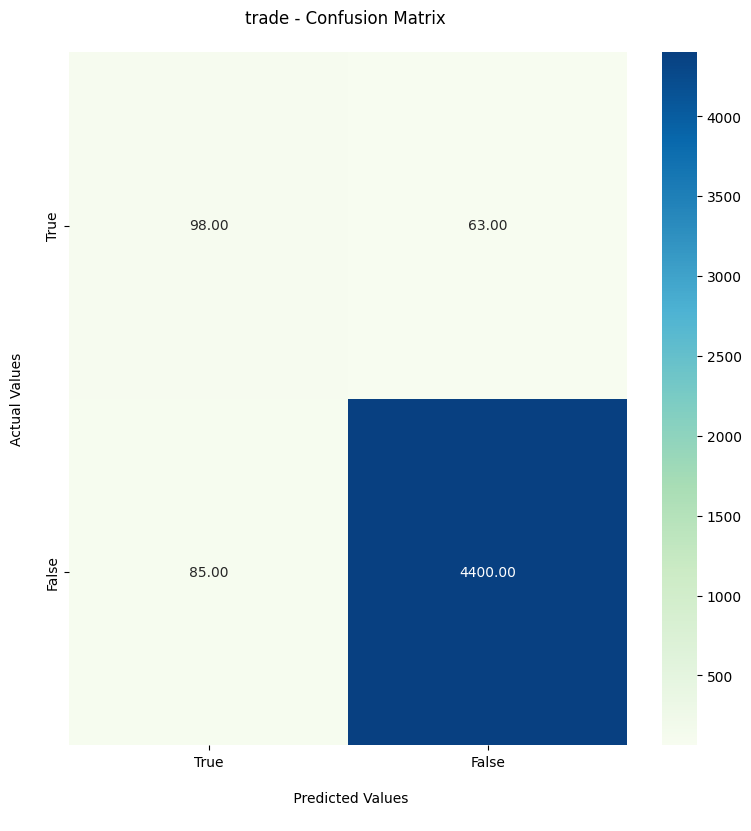

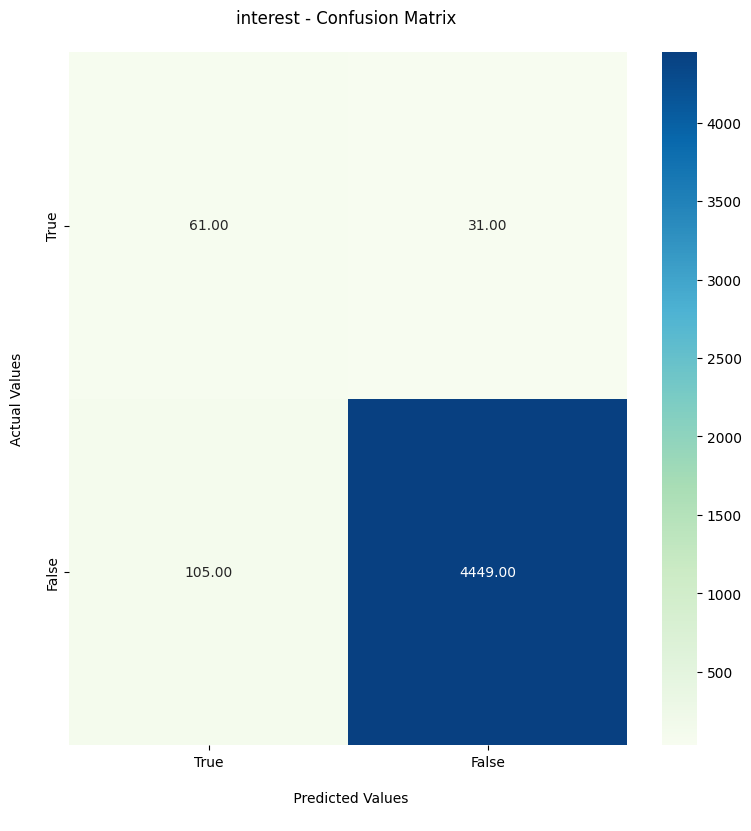

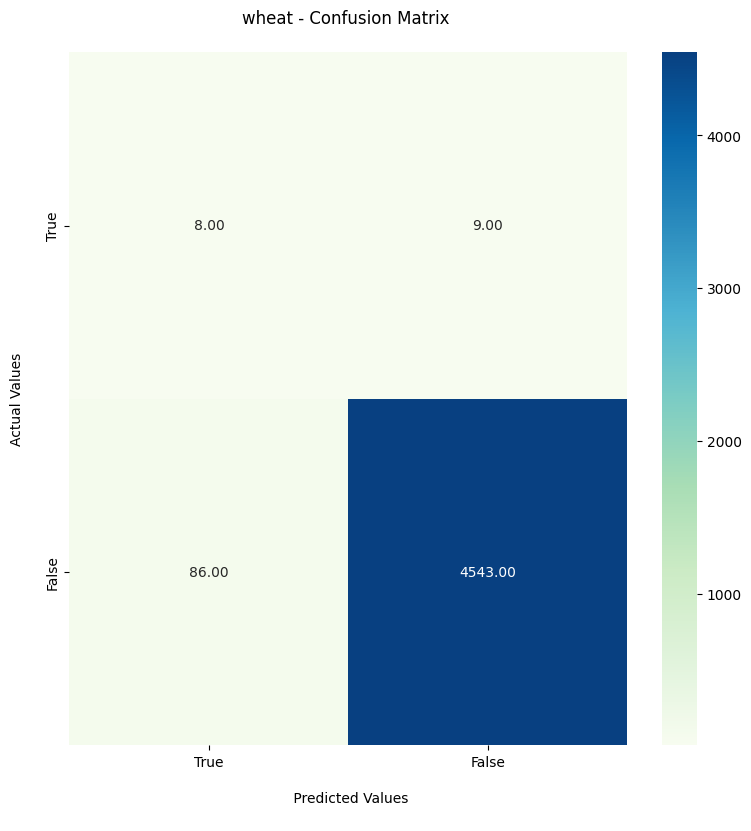

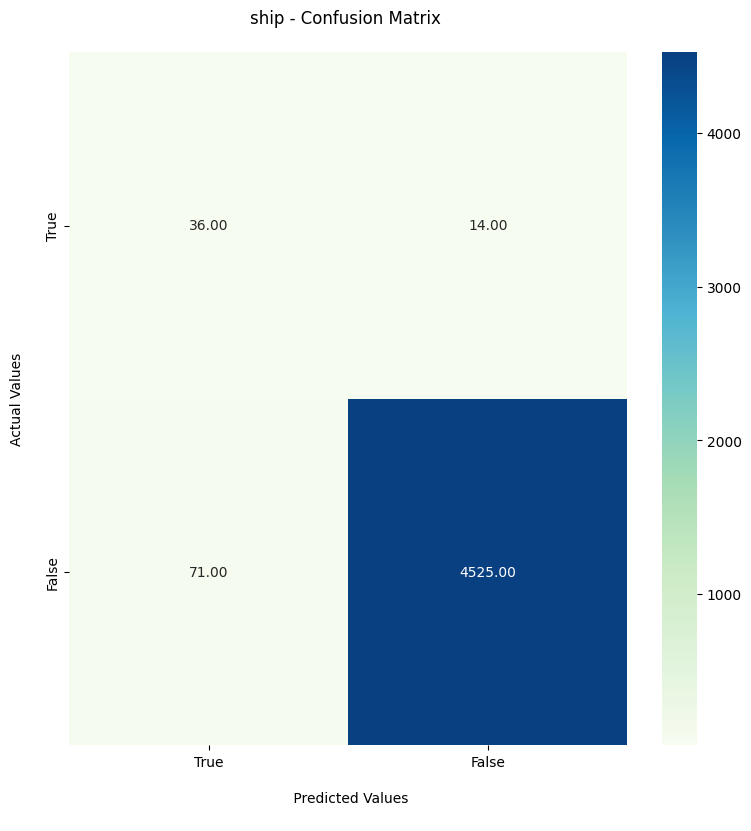

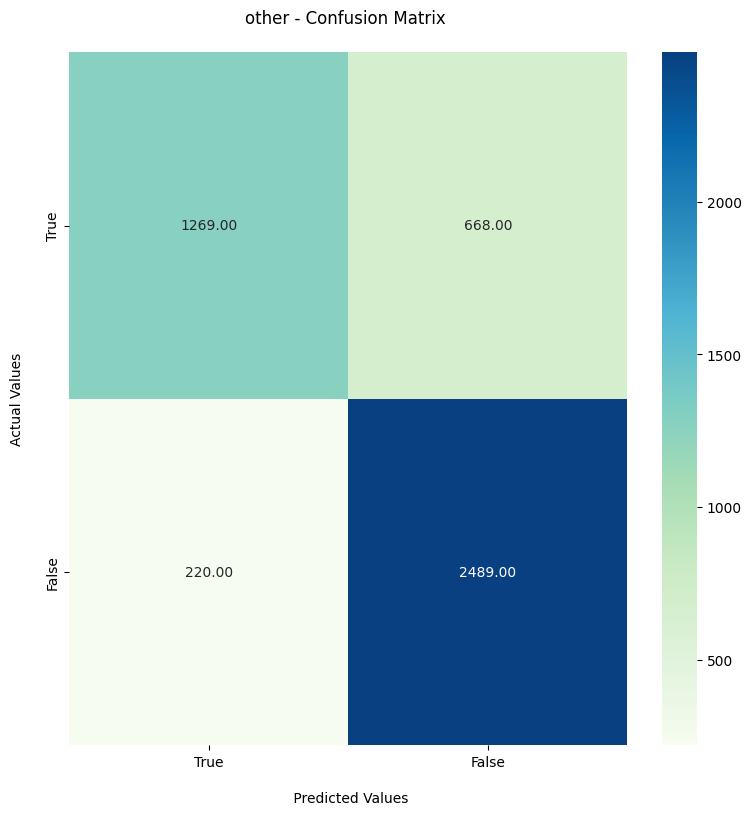

In [35]:
for e,label in zip(mcm, topic_list):
    plot_cm_heatmap(mcm_to_cm(e), title = f'{label} - Confusion Matrix \n')

In a multi-class classification the **micro scores** can be combined into:
- **macro scores** - average of micro scores
- **weighted scores** - weighted average of micro scores based on number of items in each class

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         acq       0.91      0.87      0.89       798
       crude       0.70      0.61      0.65       243
        earn       0.96      0.95      0.95      1110
       grain       0.45      0.20      0.28       194
    interest       0.66      0.37      0.47       166
    money-fx       0.49      0.45      0.47       262
       other       0.66      0.85      0.74      1489
        ship       0.72      0.34      0.46       107
       trade       0.61      0.54      0.57       183
       wheat       0.47      0.09      0.14        94

    accuracy                           0.76      4646
   macro avg       0.66      0.53      0.56      4646
weighted avg       0.75      0.76      0.74      4646



## 5. Interpretation of classification results

- Well represented classes (`acq`, `earn`, ... ) have better classifcation results. Generally precision > recall = FP is small
- `other` being a catch-all class has precision < recall.  Intuitively, because it is a *negative* class, FP and FN switch tendencies
- Despite being large classes `grain` and `wheat` have lower scores. They are similar and we can see in the global confusion values that `wheat` is mostly predicted as `grain`. 

## 6.  Ways to improve the model

1. We can use the categorical features: 'places', 'people', 'orgs', 'exchanges', 'companies', 'author'
They have a large cardinality so an one-hot encoding will not be efficient. Instead they can be target encoded based on the topic (in vectorized representation)

In [37]:
from category_encoders import TargetEncoder

def multiclass_target_encode(df, feature_col, target_col = 'target_simple'):
    targets = df[target_col].unique()
    encode_col = []
    for t in targets:
        target_aux = df[target_col].apply(lambda x: 1 if x == t else 0)
        encoder = TargetEncoder()
        cur_col = feature_col + '_tenc_' + str(t)
        df[cur_col] = encoder.fit_transform(df[target_col], target_aux)
        encode_col.append(cur_col)
    return df, encode_col

xa, encode_col = multiclass_target_encode(reuters_df[mask_train].copy(), 'author', 'topic_simple')
xa = xa[['author'] + encode_col].drop_duplicates(subset = 'author')    
xa = xa[xa['author'] != '']

xa = reuters_df.merge(xa, how = 'left')
for col in encode_col:
    m = xa[col].mean()
    xa[col] = xa[col].fillna(m)

2. We can use advanced encoding of article instead of tfidf: 
```
transformers.BertTokenizer
gensim.models.KeyedVectors
top2vec.Top2Vec
```

3. We can use a more advanced classifcation model (XGboost, CNN) instead of a simple LogisticRegression